In [227]:
import os
from pathlib import Path
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
from tqdm import tqdm 
from matplotlib.lines import Line2D

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [33]:
main_path = '/scratch/'
data_path = os.path.join(main_path,'data.pkl')
epochs_path = os.path.join(main_path,'epochs.pkl')
photostim_path = os.path.join(main_path,'photostim.pkl')
visualstim_path = os.path.join(main_path,'visualstim.pkl')

In [176]:
# take out, fixed in other runs
df_data = df_data.sort_values(by=['region', 'layer'])

In [83]:
df_data = pd.read_pickle(data_path)
df_epochs = pd.read_pickle(epochs_path)
df_photostim = pd.read_pickle(photostim_path)
df_visualstim_path = pd.read_pickle(visualstim_path)

In [340]:
def bin_spikes(spike_times, end_time, bin_size):
  """
  Bins spike events into a time series.

  Args:
    spike_times: A 1D numpy array of spike timestamps.
    end_time: The end time of the recording.
    bin_size: The desired time bin size.

  Returns:
    A tuple containing:
      - binned_spikes: A 1D numpy array where each element is the count of spikes in the corresponding time bin.
      - bin_centers: A 1D numpy array of the center timestamp for each bin.
  """
  # Create the time bins
  bins = np.arange(0, end_time + bin_size, bin_size)

  # Use numpy.histogram to count the spikes in each bin
  binned_spikes, bin_edges = np.histogram(spike_times, bins=bins)

  # Calculate the center of each bin
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

  return binned_spikes, bin_centers

#ignore start time # use swecp
def update_stim_eps_end_time(df_visualstim_path,stim_ep):
    df_interest = df_visualstim_path[df_visualstim_path['stim_name']==stim_ep] 
    df_interest = df_interest.reset_index()
    stop_times = list(df_interest['start_time'][1:])
    # getting rid of last trial, the accuracy seems to much to deal with 
    df_interest = df_interest[:-1]
    df_interest['stop_time'] = stop_times
    return df_interest

def filter_with_numpy(data_array, start_time, stop_time):
  """
  Filters a NumPy array using fast boolean indexing and subtracts the
  start time from the results.
  """
  # Create a boolean "mask" in a single, fast operation
  mask = (data_array >= start_time) & (data_array <= stop_time)

  # Apply the mask to get the filtered results
  filtered_array = data_array[mask]

  # Check if the resulting array is not empty before subtracting
  if filtered_array.size > 0:
    return filtered_array - start_time
  else:
    return filtered_array # Return the empty array as is

def plot_raster(spike_times,title,lsize = 5):
    fig, ax = plt.subplots(figsize=(10, 5))

    # The `eventplot` function is ideal for raster plots
    ax.eventplot(spike_times, color='black', linelengths=lsize)

    # --- 3. Customize the Plot ---
    ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Neuron ID')

    # Set the y-axis to show neuron indices
    #ax.set_yticks(range(len(spike_times)))
    #ax.set_yticklabels([str(i) for i in range(len(spike_times))])
    ax.set_ylim(-1, len(spike_times)) # Give some padding to the y-axis

    plt.tight_layout()
    plt.show()
    return

def raster_bny_cell_type(spike_times, cell_types):
    unique_labels = np.unique(cell_labels)
    cmap = plt.cm.get_cmap('tab10', len(unique_labels)) # A colormap good for distinct categories
    color_map = {label: cmap(i) for i, label in enumerate(unique_labels)}


    # 2. Create a list of colors, one for each neuron, based on its label
    neuron_colors = [color_map[label] for label in cell_labels]


    # 3. Create the raster plot
    fig, ax = plt.subplots(figsize=(12, 7))

    # The eventplot function is perfect for this task.
    # It takes the list of spike times and a corresponding list of colors.
    ax.eventplot(spike_times, colors=neuron_colors, linelengths=20)

    ax.set_title('Raster Plot Organized by Cell Type')
    ax.set_xlabel('Time (s)')
    ax.set_xlim(left=0) # Ensure the plot starts at time 0
    ax.set_ylim(-1, len(spike_times)) # Set y-axis limits correctly


    # 4. Create a custom legend to identify the cell types
    legend_elements = [Line2D([0], [0], color=color_map[label], lw=4, label=label)
                       for label in unique_labels]
    ax.legend(handles=legend_elements, title="Cell Types", bbox_to_anchor=(1.05, 1), loc='upper left')


    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()
    return

def extract_spikes(df_interest,stim_ep,main_path):
    stim_ep_path = os.path.join(main_path,stim_ep)
    df_interest = update_stim_eps_end_time(df_visualstim_path, stim_ep)
    if not os.path.exists(stim_ep_path):
        os.makedirs(stim_ep_path)
    else:
        pass
    df_interest.to_csv(os.path.join(stim_ep_path,'trial_info.csv'))
    spikes = df_data[f"{stim_ep}_spikes"].values
    # saves trials (each individual epoch) as its indiviual pickle file for more efficient loading
    pbar = tqdm(total = len(df_interest),leave = True,position = 0)
    for i in range(len(df_interest)):
        start_time = df_interest.iloc[0]['start_time']
        stop_time = df_interest.iloc[0]['stop_time']
        dur = stop_time - start_time
        new_array = [filter_with_numpy(spikes[i], start_time, stop_time) for i in range(spikes.shape[0])]
        new_array.append(dur)
        filename = os.path.join(stim_ep_path, f'trial_array_{i}.pkl')
        with open(filename, 'wb') as f:
            pickle.dump(new_array, f)
        pbar.update(1)
    return


In [343]:
# extract the timging for each events
stim_ep = 'RFMapping_0'
extract_spikes(df_interest,stim_ep,main_path)

100%|██████████| 2322/2322 [00:48<00:00, 48.03it/s]


In [298]:
trial_number = 0
file_path = os.path.join(stim_ep_path, f'trial_array_{trial_number}.pkl')
with open(file_path,'rb') as f:
    spike_times = pickle.load(f)

In [346]:
x_coords = df_data['estimated_x'].values
y_coords = df_data['estimated_y'].values
z_coords = df_data['estimated_y'].values

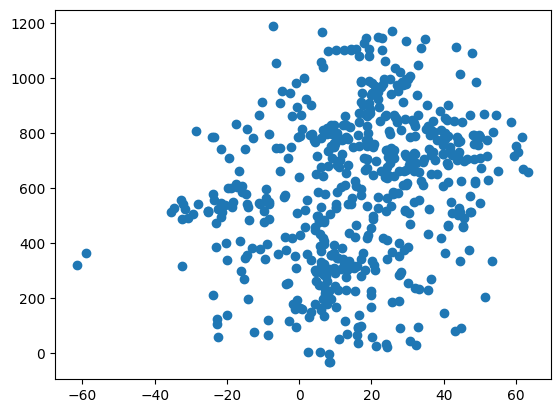

In [347]:
plt.scatter(x_coords,y_coords)

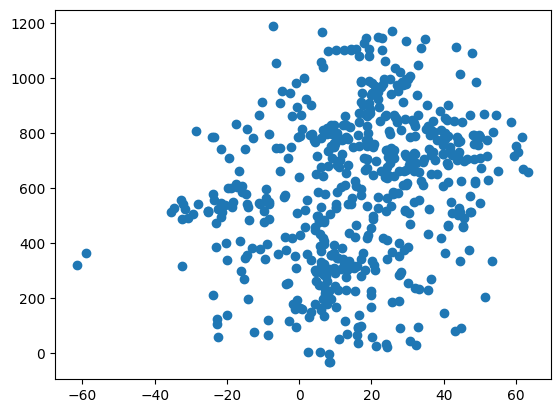

In [348]:
plt.scatter(x_coords,z_coords)

In [ ]:
df_data.layer.unique()

array(['MOs2/3', 'MOs5', 'MOs6a', 'RSPd1', 'RSPd2/3', 'RSPd5', 'RSPd6a',
       'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a',
       'SSp-bfd6b', 'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a',
       'VISp6b', 'cing', 'dhc', 'fp', 'root'], dtype=object)

In [319]:
df_data.cell_type.unique()
#sim1 : layer 5 
#Rs regular spiking (proxy excitatory)
# fsl : large fast spiking; unit 
#FSS


array(['Sim1', 'RS', 'FSl', 'FSs'], dtype=object)

In [320]:
df_data.region.unique()

array(['MOs', 'RSPd', 'SSp', 'VISp', 'cing', 'dhc', 'fp', 'root'],
      dtype=object)

In [309]:
cell_labels = df_data.cell_type.values

In [ ]:
unique_cell_types = np.unique(cell_labels)
colors = plt.cm.get_cmap('tab10', len(unique_cell_types))
color_map = {cell_type: colors(i) for i, cell_type in enumerate(unique_cell_types)}

/tmp/ipykernel_112/3119358936.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_cell_types))


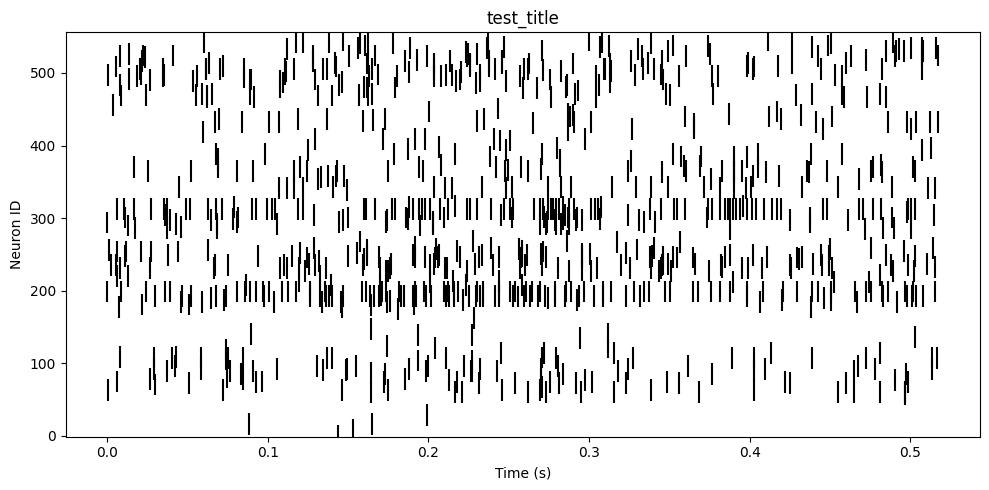

In [ ]:
plot_raster(spike_times,'test_title',lsize = 30)

/tmp/ipykernel_112/1802622406.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_labels)) # A colormap good for distinct categories


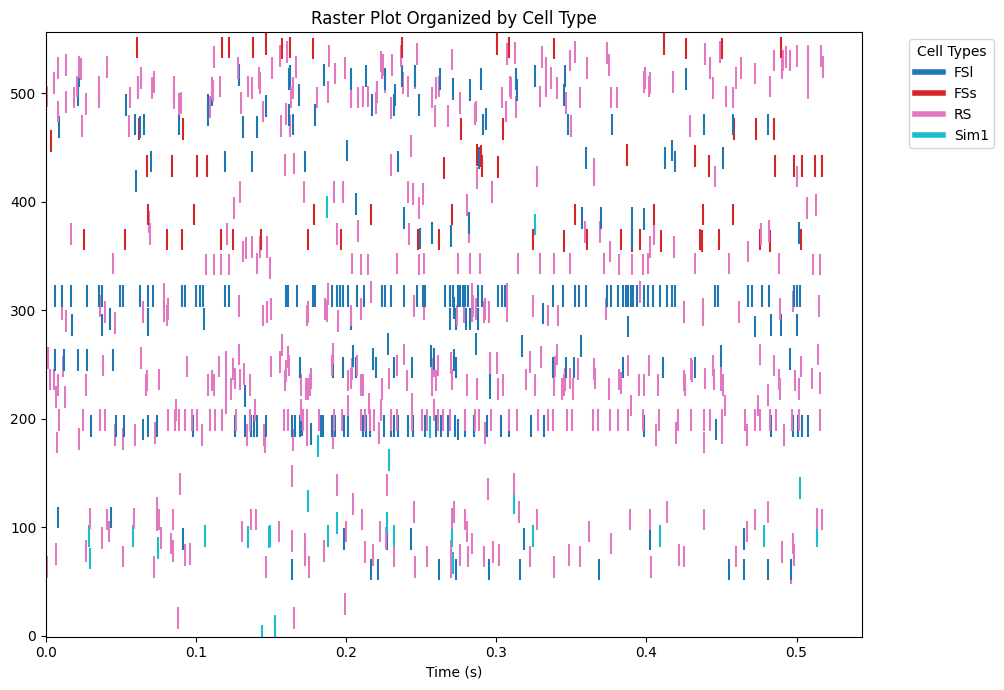

# Testing binning

In [270]:
spike_times[313]

array([0.00617578, 0.0104091 , 0.01674242, 0.02707573, 0.03547571,
       0.03700904, 0.04927568, 0.05154234, 0.06274231, 0.06800897,
       0.07137563, 0.09030892, 0.09247558, 0.0996089 , 0.10267556,
       0.10467555, 0.11890885, 0.12194218, 0.15960876, 0.16117542,
       0.16697541, 0.17760872, 0.17944205, 0.19017536, 0.19380868,
       0.19597534, 0.19790867, 0.201242  , 0.20710865, 0.21187531,
       0.22414195, 0.22584194, 0.22994193, 0.23870858, 0.24687523,
       0.25084189, 0.25267522, 0.26557519, 0.26927518, 0.27124184,
       0.2742085 , 0.27597516, 0.27754183, 0.27940849, 0.28124182,
       0.2875418 , 0.29050846, 0.30140844, 0.3035751 , 0.30554176,
       0.33764169, 0.34470834, 0.35264166, 0.35474165, 0.35987497,
       0.37380827, 0.37660827, 0.38137492, 0.38440825, 0.38620825,
       0.38790824, 0.38944157, 0.39124157, 0.39380823, 0.39827488,
       0.40130821, 0.40410821, 0.40914153, 0.41384152, 0.41694151,
       0.41930817, 0.44554144, 0.44790811, 0.46784139, 0.47064

In [274]:
test1,test2 = bin_spikes(spike_times[313], end_time, 0.05)

In [349]:
unique_labels = np.unique(cell_labels)
cmap = plt.cm.get_cmap('tab10', len(unique_labels)) # A colormap good for distinct categories
color_map = {label: cmap(i) for i, label in enumerate(unique_labels)}


/tmp/ipykernel_112/3905423823.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_labels)) # A colormap good for distinct categories


In [350]:
neuron_colors = [color_map[label] for label in cell_labels]
